In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../modules')
from utils import climate
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
dir_data = '../data/eca_data/'

In [4]:
stations_pres = climate.eca_read_station_like_file("ECA_blend_station_pp.txt", directory = dir_data)
stations_prec = climate.eca_read_station_like_file("ECA_blend_station_rr.txt", directory = dir_data)
stations_tavg = climate.eca_read_station_like_file("ECA_blend_station_tg.txt", directory = dir_data)
stations_rads = climate.eca_read_station_like_file("ECA_blend_station_qq.txt", directory = dir_data)

stations_dict = {'pp' : stations_pres, 'rr' : stations_prec, 'tg' : stations_tavg, 'qq' : stations_rads}

stations = pd.concat([stations_pres, stations_prec,stations_tavg,stations_rads ]).drop_duplicates().reset_index(drop=True)

In [5]:
stations_pres

,STAID,STANAME,CN,LAT,LON,HGHT
0,1,VAEXJOE,SE,56.866667,14.800000,166
1,2,FALUN,SE,60.616667,15.616667,160
2,3,STENSELE,SE,65.066667,17.150000,325
3,5,LINKOEPING-MALMSLAETT,SE,58.400000,15.516667,93
4,7,KARLSTAD-AIRPORT,SE,59.433333,13.333333,107
...,...,...,...,...,...,...
2636,26653,LENARDDAROC,HU,48.133333,20.366667,278
2637,26660,EDELENY-1,HU,48.283333,20.733333,130
2638,26661,NYIREGYHAZA REPULOTER (ESZAK),HU,47.983333,21.683333,103
2639,26662,BODA,HU,46.083333,18.033333,233


In [6]:
dataframes = []
for measure, stations in stations_dict.items():
    for _, row in stations.iterrows():
        if(_ % 500 == 0):
            print(_)
        stat_id = row['STAID']
        filename = "ECA_blend_%s/%s_STAID%06i.txt" % (measure, measure.upper(),stat_id)
        df = climate.eca_read_station_like_file(filename, directory = dir_data)
        df['DATE'] = pd.to_datetime(df['DATE'], format="%Y%m%d")
        df[df == -9999] = np.nan
        df.dropna(axis=0, inplace=True)
        df = df[['STAID', 'DATE', measure.upper()]]
        df.rename({'STAID': 'station_id', 'DATE' : 'date', measure.upper() : 'value' }, axis=1, inplace=True)
        df['measure'] = measure
        df.set_index(['station_id', 'measure', 'date'], drop=True, inplace=True)
        dataframes.append(df)
dataframes = pd.concat(dataframes, axis=0)

0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
0
500
1000
1500
2000


In [35]:
dataframes.to_parquet('../data/eca_data/eca_data.parquet', compression='gzip')

In [545]:
tgdf = dataframes.xs('tg', level='measure')

<Axes: xlabel='date'>

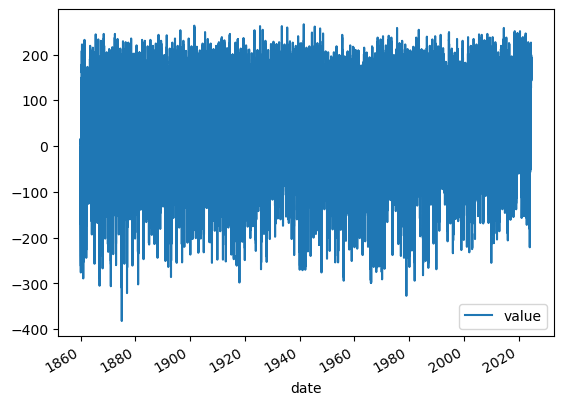

In [549]:
tgdf.xs(2, level='station_id').plot(y='value')

In [556]:
# for every date, average the temperature of all stations
testtg = tgdf.groupby('date').mean()
# cut the dates before 1950
testtg = testtg[testtg.index > pd.to_datetime('1950-01-01')]
# multiply the temperature by 10
testtg['value'] = testtg['value'] * 0.1

(-3653.0, 19723.0)

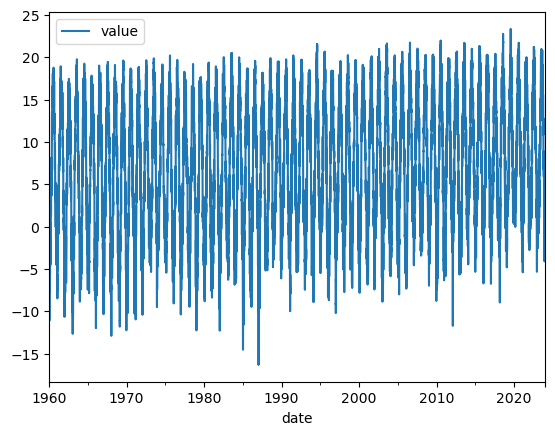

In [560]:
# plot the temperature
testtg.plot()
plt.xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('2024-01-01'))

(18262.0, 18628.0)

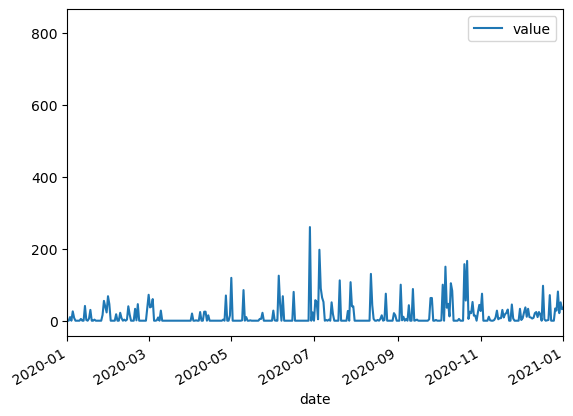

In [533]:
dataframes.xs(2, level='station_id').xs('rr', level='measure').plot(y='value')
plt.xlim(np.datetime64('2020-01-01'), np.datetime64('2021-01-01'))

In [ ]:
measure_x = 'pp'
measure_y = 'tg'
subset_pptg = pd.merge(dataframes.xs(measure_x, level='measure'),
                  dataframes.xs(measure_y, level='measure'),
                  left_index=True, right_index=True, how='inner')

In [521]:
measure_x = 'rr'
measure_y = 'tg'
subset_rrtg = pd.merge(dataframes.xs(measure_x, level='measure'),
                  dataframes.xs(measure_y, level='measure'),
                  left_index=True, right_index=True, how='inner')

KeyboardInterrupt: 

In [37]:
stations_df = stations_dict[measure_x]

In [473]:
mutual_variance = {}
mutual_info = {}
mutual_fano = {}
mutual_precision = {}
mutual_sumprefan = {}
for station_id, group in subset.groupby('station_id'):
    group_indexed = group.reset_index(level='station_id', drop=True)
    
    rolling_cov = group_indexed['value_x'].rolling('30D').cov(group_indexed['value_y'])
    rolling_varx = group_indexed['value_x'].rolling('30D').var()
    rolling_vary = group_indexed['value_y'].rolling('30D').var()
    
    mutual_info[station_id] = 0.5*np.log((rolling_varx*rolling_vary)/(rolling_varx*rolling_vary-rolling_cov*rolling_cov))
    mutual_variance[station_id] = 1- np.exp(-2*mutual_info[station_id]) #only for 2 vars
    mutual_fano[station_id] = mutual_variance[station_id]/mutual_info[station_id]
    mutual_precision[station_id] = mutual_info[station_id]**2/mutual_variance[station_id]
    mutual_sumprefan[station_id] = (mutual_precision[station_id] + 2 - mutual_fano[station_id])/2

/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


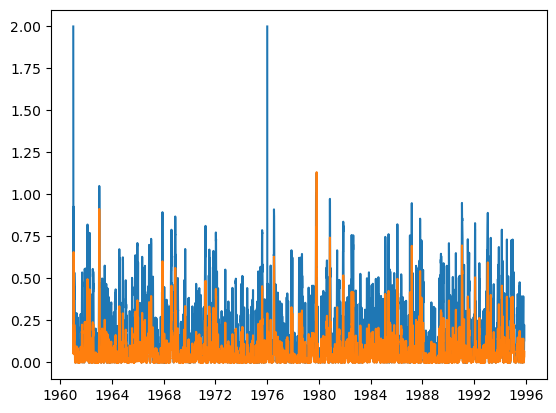

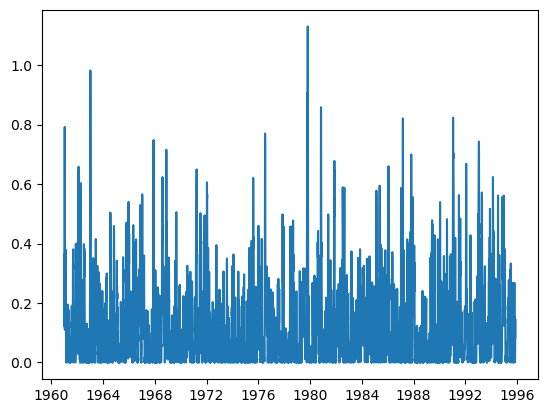

In [475]:
plt.plot(2 - mutual_fano[1])
plt.plot(mutual_precision[1])
plt.show()
plt.plot(mutual_sumprefan[1])

In [512]:
mutual_fano_means = []
mutual_fano_stds = []
mutual_means = []
mutual_stds = []
mutual_precision_means = []
mutual_precision_stds = []
mutual_sumprefan_means = []
mutual_sumprefan_stds = []
for i, (k, v) in enumerate(mutual_fano.items()):
    mean_v = np.nanmean(v)
    std_v = np.nanstd(v)
    if ~np.isnan(v).all() and mean_v != 0:
        mutual_fano_means.append([k, mean_v])
        mutual_fano_stds.append([k, std_v])
    else:
        print(k)

mutual_fano_means = np.array(mutual_fano_means)
mutual_fano_stds = np.array(mutual_fano_stds)

for i, (k, v) in enumerate(mutual_info.items()):
    mean_v = np.nanmean(v[~np.isinf(v)])
    std_v = np.nanstd(v[~np.isinf(v)])
    if ~np.isnan(v).all() and mean_v != 0:
        mutual_means.append([k, mean_v])
        mutual_stds.append([k, std_v])
    else:
        print(k)

mutual_means = np.array(mutual_means)
mutual_stds = np.array(mutual_stds)

for i, (k, v) in enumerate(mutual_precision.items()):
    mean_v = np.nanmean(v[~np.isinf(v)])
    std_v = np.nanstd(v[~np.isinf(v)])
    if ~np.isnan(v).all() and mean_v != 0 and ~np.isinf(v).all():
        mutual_precision_means.append([k, mean_v])
        mutual_precision_stds.append([k, std_v])
    else:
        print(k)

mutual_precision_means = np.array(mutual_precision_means)
mutual_precision_stds = np.array(mutual_precision_stds)

for i, (k, v) in enumerate(mutual_sumprefan.items()):
    mean_v = np.nanmean(v[~np.isinf(v)])
    std_v = np.nanstd(v[~np.isinf(v)])
    if ~np.isnan(v).all() and mean_v != 0 and ~np.isinf(v).all():
        mutual_sumprefan_means.append([k, mean_v])
        mutual_sumprefan_stds.append([k, std_v])
    else:
        print(k)

mutual_sumprefan_means = np.array(mutual_sumprefan_means)
mutual_sumprefan_stds = np.array(mutual_sumprefan_stds)

58
3987
4009
4408
4451
5439


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/1048876573.py:10: RuntimeWarning: Mean of empty slice
  mean_v = np.nanmean(v)


18122
18177
19017
19154
23356
23464
23468


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/1048876573.py:22: RuntimeWarning: Mean of empty slice
  mean_v = np.nanmean(v[~np.isinf(v)])


4009
4408
4451
5439
19017
23468


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/1048876573.py:34: RuntimeWarning: Mean of empty slice
  mean_v = np.nanmean(v[~np.isinf(v)])


4009
4408
4451
5439
19017
23468


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/1048876573.py:46: RuntimeWarning: Mean of empty slice
  mean_v = np.nanmean(v[~np.isinf(v)])


4009
4408
4451
5439
19017
23468


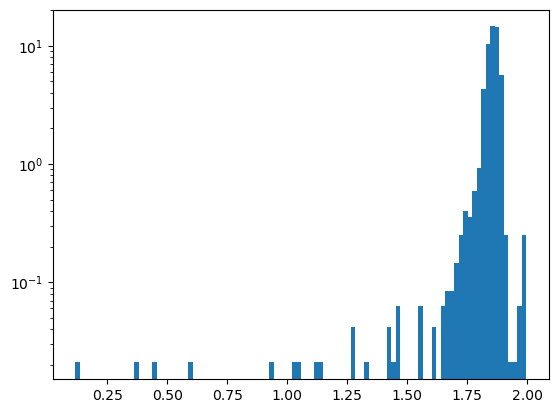

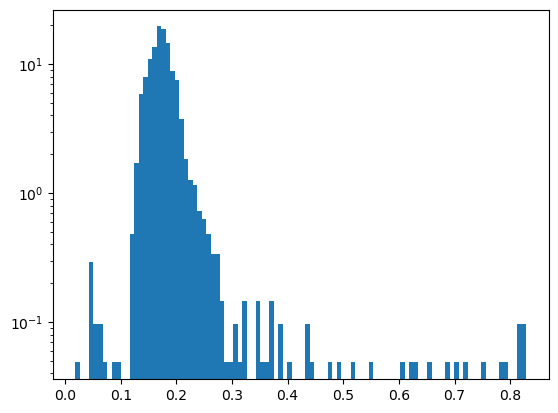

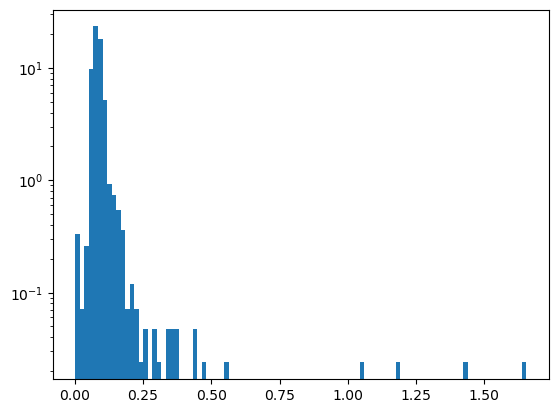

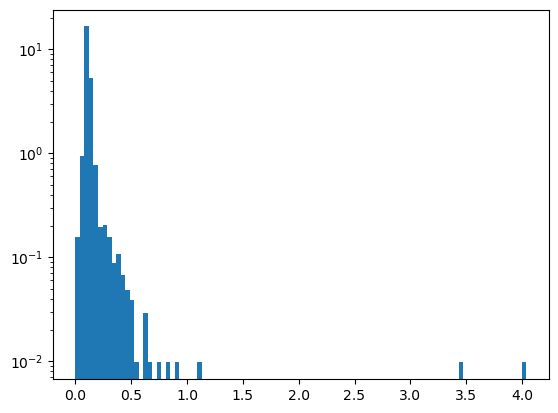

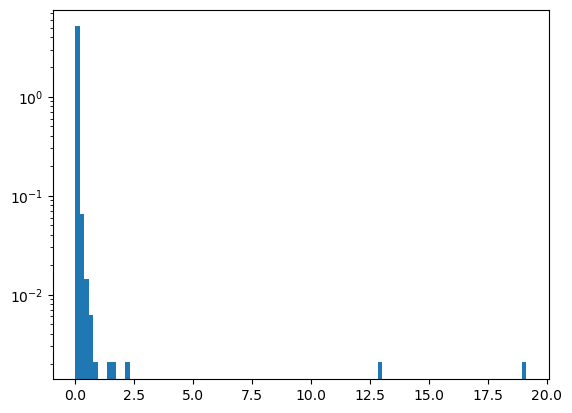

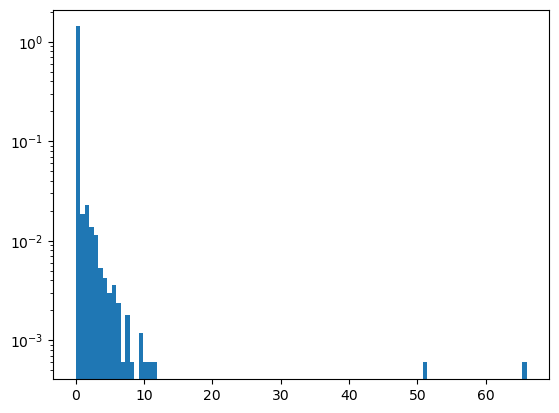

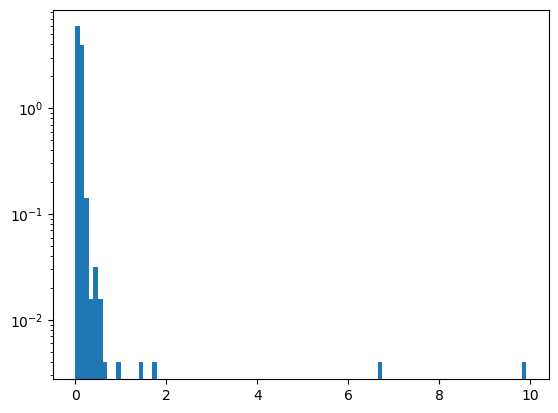

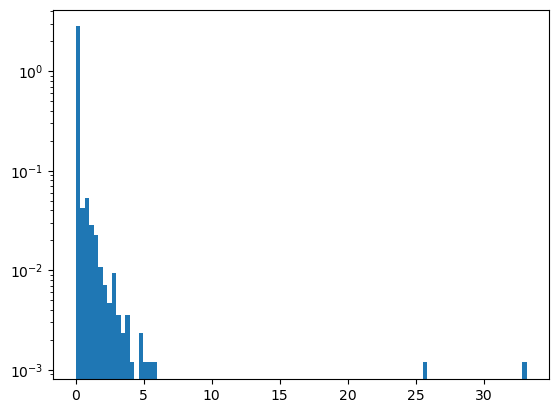

In [513]:
plt.hist(mutual_fano_means[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_fano_stds[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_means[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_stds[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_precision_means[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_precision_stds[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_sumprefan_means[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

plt.hist(mutual_sumprefan_stds[:, 1], bins=100, density=True)
plt.yscale('log')
plt.show()

In [255]:
count_below_th = np.zeros(mutual_fano_means.shape[0])
th = 3

for i, (k, series) in enumerate(mutual_fano.items()):
    idx = np.where(mutual_fano_means[:, 0] == k)[0]
    if len(idx) == 0:
        continue
    
    # select only the items that are not nan and not zero
    series = np.array(series[~np.isnan(series)])
    series = series[series != 0]

    mv = mutual_fano_means[idx[0]][1]
    std = mutual_fano_stds[idx[0]][1]

    count_below_th[idx] = np.sum(series < mv - th*std)

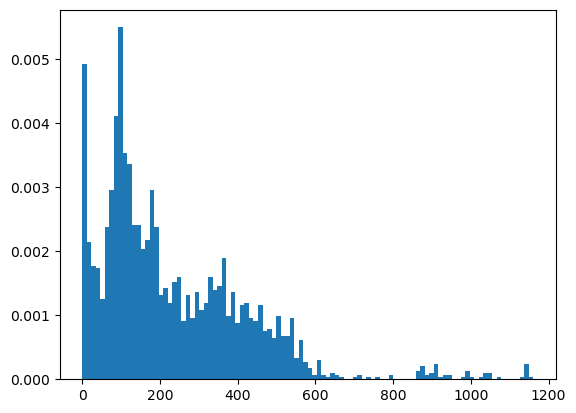

In [256]:
plt.hist(count_below_th, bins=100, density=True)
plt.show()

In [484]:
locs = np.zeros((mutual_fano_means.shape[0], 2))
for i, (station_id, mean_fano) in enumerate(mutual_fano_means):
    locs[i] = stations_df[stations_df['STAID'] == station_id][['LAT', 'LON']].values[0]

In [485]:
import matplotlib

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/3695365955.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


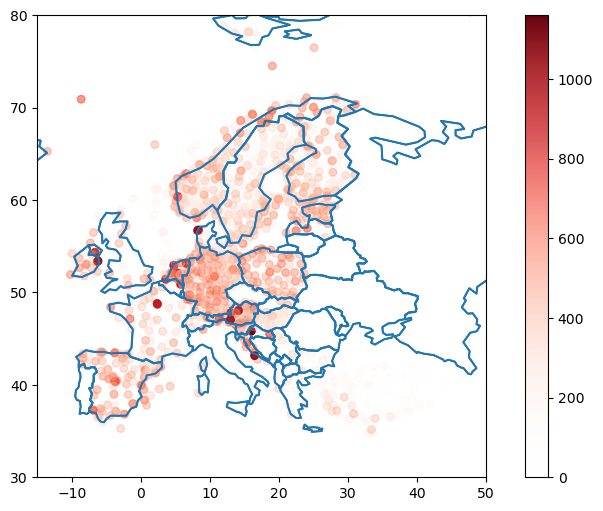

In [259]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

fig, ax = plt.subplots(figsize=(10,6))
europe.boundary.plot(ax=ax)
europe.plot(ax=ax, color='white', edgecolor='black')

cmap = matplotlib.colormaps["Reds"]
cmap._init()
cmap._lut[:,-1] = np.linspace(0, 1, cmap.N + 3)

im = ax.scatter(locs[:, 1], locs[:, 0], c = (count_below_th), cmap=cmap,
                s = 30)
plt.colorbar(im)
plt.xlim(-15, 50)
plt.ylim(30, 80)
plt.show()

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/2984210019.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


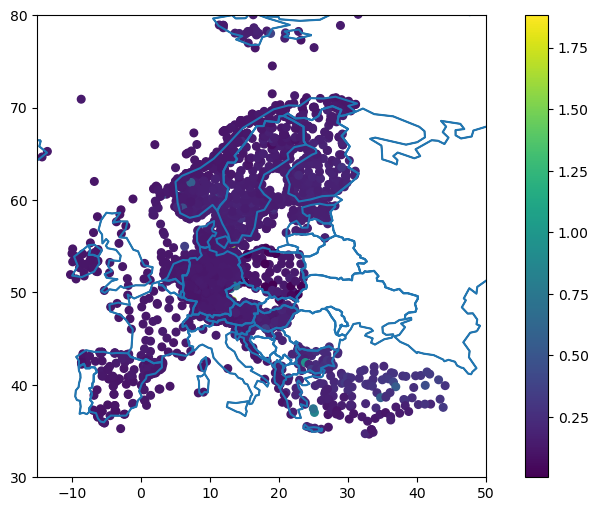

In [242]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

vmin = np.nanmin(2 - mutual_fano_means[:, 1])
vmax = np.nanmax(2 - mutual_fano_means[:, 1])

fig, ax = plt.subplots(figsize=(10,6))
europe.boundary.plot(ax=ax)
europe.plot(ax=ax, color='white', edgecolor='black')

cmap = matplotlib.colormaps["viridis"]
#add trasparency

im = ax.scatter(locs[:, 1], locs[:, 0], c= 2 - mutual_fano_means[:, 1], cmap=cmap, vmin=vmin, vmax=vmax,
                s = 30)
plt.colorbar(im)
plt.xlim(-15, 50)
plt.ylim(30, 80)
plt.show()

In [514]:
loc_dict = {}
for i, (k, series) in enumerate(mutual_fano.items()):
    location = stations_df[stations_df['STAID'] == k][['LAT', 'LON']].values.flatten()
    loc_dict[k] = location

In [518]:
# Precompute data for all frames
dates = np.arange(np.datetime64('2021-06-01'), np.datetime64('2021-09-01'))
precomputed_data_fano = {}
precomputed_data_mutual = {}
precomputed_data_precision = {}
precomputed_data_sumprefan = {}
vmax_fano = -np.inf
vmax_mutual = -np.inf
vmax_precision = -np.inf
vmax_sumprefan = -np.inf
for date in dates:
    data_plot_fano = []
    data_plot_mutual = []
    data_plot_precision = []
    data_plot_sumprefan = []
    for stat_id in mutual_fano.keys():
        fano = mutual_fano[stat_id]
        mutual = mutual_info[stat_id]
        precision = mutual_precision[stat_id]
        sumprefan = mutual_sumprefan[stat_id]

        location = loc_dict[stat_id]
        values_fano = fano.values[fano.index == date]
        values_mutual = mutual.values[mutual.index == date]
        values_precision = precision.values[precision.index == date]
        values_sumprefan = sumprefan.values[sumprefan.index == date]
        
        if len(values_fano) != 0:
            if values_fano[0] != 0:
                data_plot_fano.append((location[0], location[1], 2 - values_fano[0]))
                if 2 - values_fano[0] > vmax_fano:
                    vmax_fano = 2 - values_fano[0]

        if len(values_mutual) != 0:
            if values_mutual[0] != 0 and ~np.isinf(values_mutual[0]):
                data_plot_mutual.append((location[0], location[1], values_mutual[0]))
                if values_mutual[0] > vmax_mutual:
                    vmax_mutual = values_mutual[0]

        if len(values_precision) != 0:
            if values_precision[0] != 0 and ~np.isinf(values_precision[0]):
                data_plot_precision.append((location[0], location[1], values_precision[0]))
                if values_precision[0] > vmax_precision:
                    vmax_precision = values_precision[0]

        if len(values_sumprefan) != 0:
            if values_sumprefan[0] != 0 and ~np.isinf(values_sumprefan[0]):
                data_plot_sumprefan.append((location[0], location[1], values_sumprefan[0]))
                if values_sumprefan[0] > vmax_sumprefan:
                    vmax_sumprefan = values_sumprefan[0]
        
    precomputed_data_fano[date] = np.array(data_plot_fano)
    precomputed_data_mutual[date] = np.array(data_plot_mutual)
    precomputed_data_precision[date] = np.array(data_plot_precision)
    precomputed_data_sumprefan[date] = np.array(data_plot_sumprefan)

In [ ]:
print(vmax_fano, vmax_mutual, vmax_precision, vmax_sumprefan)

1.9199941299318768 12.499082868977117 156.22707256773091 79.07353334883139


Frame: 0, Date: 2021-06-01, Data Fano: (1914, 3), Data Mutual: (1914, 3), Data Precision: (1914, 3), Data Sumprefan: (1914, 3)
Frame: 1, Date: 2021-06-02, Data Fano: (1915, 3), Data Mutual: (1915, 3), Data Precision: (1915, 3), Data Sumprefan: (1915, 3)
Frame: 2, Date: 2021-06-03, Data Fano: (1907, 3), Data Mutual: (1907, 3), Data Precision: (1907, 3), Data Sumprefan: (1907, 3)
Frame: 3, Date: 2021-06-04, Data Fano: (1916, 3), Data Mutual: (1916, 3), Data Precision: (1916, 3), Data Sumprefan: (1916, 3)
Frame: 4, Date: 2021-06-05, Data Fano: (1916, 3), Data Mutual: (1916, 3), Data Precision: (1916, 3), Data Sumprefan: (1916, 3)
Frame: 5, Date: 2021-06-06, Data Fano: (1916, 3), Data Mutual: (1916, 3), Data Precision: (1916, 3), Data Sumprefan: (1916, 3)
Frame: 6, Date: 2021-06-07, Data Fano: (1916, 3), Data Mutual: (1916, 3), Data Precision: (1916, 3), Data Sumprefan: (1916, 3)
Frame: 7, Date: 2021-06-08, Data Fano: (1915, 3), Data Mutual: (1915, 3), Data Precision: (1915, 3), Data Sumpr

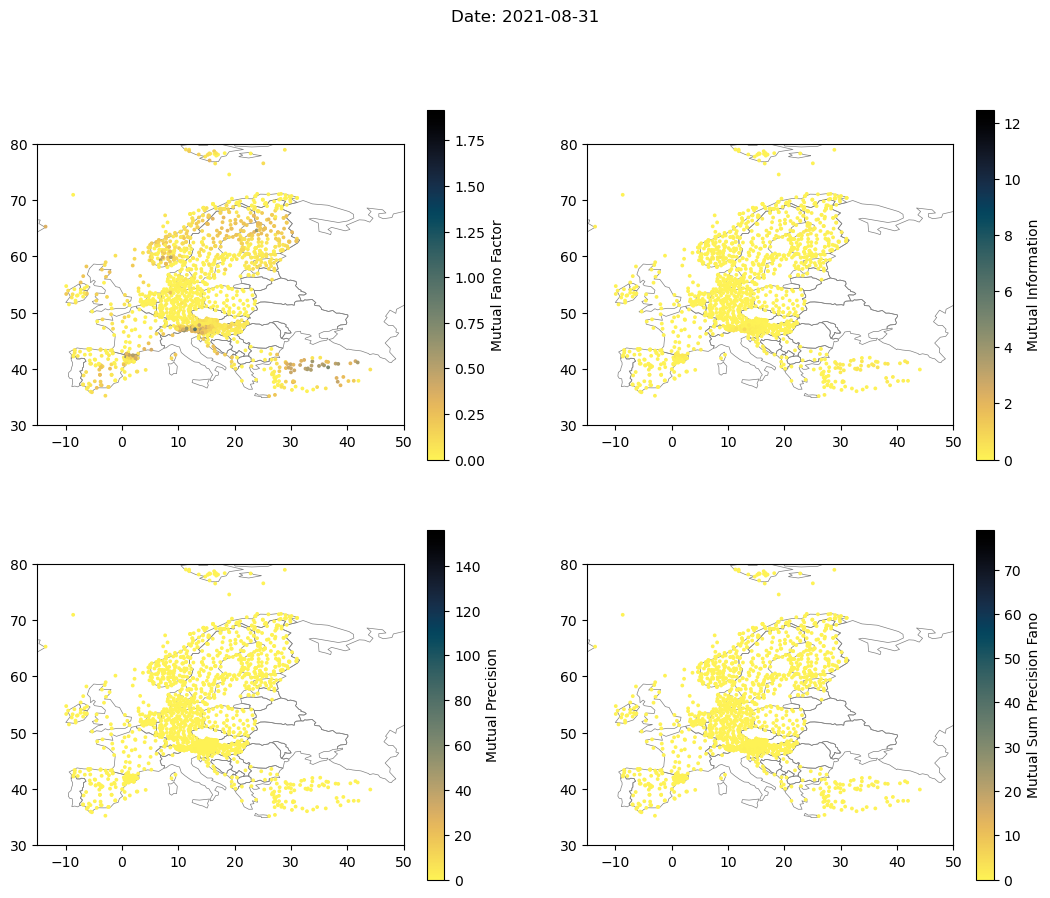

In [520]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))
ax1, ax2, ax3, ax4 = axs.flatten()

for a in axs.flatten():
    a.set_xlim(-15, 50)
    a.set_ylim(30, 80)
    europe.boundary.plot(ax=a, lw=0.5, color='gray', zorder=-np.inf)
    a.set_aspect('equal')

# initialize the color maps
cmap = plt.get_cmap('cmr.eclipse_r')
cmap.set_bad((0,0,0,0))

# Create ScalarMappables for the colorbars
norm_fano = matplotlib.colors.Normalize(vmin=0, vmax=vmax_fano)
norm_mutual = matplotlib.colors.Normalize(vmin=0, vmax=vmax_mutual)
norm_precision = matplotlib.colors.Normalize(vmin=0, vmax=vmax_precision)
norm_sumprefan = matplotlib.colors.Normalize(vmin=0, vmax=vmax_sumprefan)

# Create ScalarMappables for the colorbars
sm_fano = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm_fano)
sm_mutual = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm_mutual)
sm_precision = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm_precision)
sm_sumprefan = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm_sumprefan)

# Create colorbars
cbar_fano = fig.colorbar(sm_fano, ax=ax1, label='Mutual Fano Factor')
cbar_mutual = fig.colorbar(sm_mutual, ax=ax2, label='Mutual Information')
cbar_precision = fig.colorbar(sm_precision, ax=ax3, label='Mutual Precision')
cbar_sumprefan = fig.colorbar(sm_sumprefan, ax=ax4, label='Mutual Sum Precision Fano')

# Initialize the scatter plots
sc_fano = ax1.scatter([], [], s=3, c=[], cmap=cmap, norm=norm_fano)
sc_mutual = ax2.scatter([], [], s=3, c=[], cmap=cmap, norm=norm_mutual)
sc_precision = ax3.scatter([], [], s=3, c=[], cmap=cmap, norm=norm_precision)
sc_sumprefan = ax4.scatter([], [], s=3, c=[], cmap=cmap, norm=norm_sumprefan)

# Initialize the scatter plots
def init():
    sc_fano.set_offsets(np.empty((0, 2)))
    sc_fano.set_array([])

    sc_mutual.set_offsets(np.empty((0, 2)))
    sc_mutual.set_array([])

    sc_precision.set_offsets(np.empty((0, 2)))
    sc_precision.set_array([])
    
    sc_sumprefan.set_offsets(np.empty((0, 2)))
    sc_sumprefan.set_array([])
    return sc_fano, sc_mutual, sc_precision, sc_sumprefan

# Update the scatter plots
def update(frame):
    date = dates[frame]
    data_plot_fano = precomputed_data_fano[date]
    data_plot_mutual = precomputed_data_mutual[date]
    data_plot_precision = precomputed_data_precision[date]
    data_plot_sumprefan = precomputed_data_sumprefan[date]
    
    print(f"Frame: {frame}, Date: {date}, Data Fano: {data_plot_fano.shape}, Data Mutual: {data_plot_mutual.shape}, Data Precision: {data_plot_precision.shape}, Data Sumprefan: {data_plot_sumprefan.shape}")
    if data_plot_fano.ndim == 2 and data_plot_fano.shape[0] > 0:
        sc_fano.set_offsets(data_plot_fano[:, [1, 0]])
        sc_fano.set_array(data_plot_fano[:, 2])
    else:
        sc_fano.set_offsets(np.empty((0, 2)))
        sc_fano.set_array(np.array([]))
    if data_plot_mutual.ndim == 2 and data_plot_mutual.shape[0] > 0:
        sc_mutual.set_offsets(data_plot_mutual[:, [1, 0]])
        sc_mutual.set_array(data_plot_mutual[:, 2])
    else:
        sc_mutual.set_offsets(np.empty((0, 2)))
        sc_mutual.set_array(np.array([]))
    if data_plot_precision.ndim == 2 and data_plot_precision.shape[0] > 0:
        sc_precision.set_offsets(data_plot_precision[:, [1, 0]])
        sc_precision.set_array(data_plot_precision[:, 2])
    else:
        sc_precision.set_offsets(np.empty((0, 2)))
        sc_precision.set_array(np.array([]))
    if data_plot_sumprefan.ndim == 2 and data_plot_sumprefan.shape[0] > 0:
        sc_sumprefan.set_offsets(data_plot_sumprefan[:, [1, 0]])
        sc_sumprefan.set_array(data_plot_sumprefan[:, 2])
    else:
        sc_sumprefan.set_offsets(np.empty((0, 2)))
        sc_sumprefan.set_array(np.array([]))
    fig.suptitle(f"Date: {date}")
    return sc_fano, sc_mutual, sc_precision, sc_sumprefan

# Create the animation
ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=100)
# Save the animation as a video file (optional)
ani.save('animation_all_july2021.mp4', writer='ffmpeg')

plt.show()

Frame: 0, Date: 2010-01-01, Data Plot Fano Shape: (1820, 3), Data Plot Mutual Shape: (1820, 3)
Frame: 1, Date: 2010-01-02, Data Plot Fano Shape: (1828, 3), Data Plot Mutual Shape: (1828, 3)
Frame: 2, Date: 2010-01-03, Data Plot Fano Shape: (1828, 3), Data Plot Mutual Shape: (1828, 3)
Frame: 3, Date: 2010-01-04, Data Plot Fano Shape: (1835, 3), Data Plot Mutual Shape: (1835, 3)
Frame: 4, Date: 2010-01-05, Data Plot Fano Shape: (1835, 3), Data Plot Mutual Shape: (1835, 3)
Frame: 5, Date: 2010-01-06, Data Plot Fano Shape: (1840, 3), Data Plot Mutual Shape: (1840, 3)
Frame: 6, Date: 2010-01-07, Data Plot Fano Shape: (1841, 3), Data Plot Mutual Shape: (1841, 3)
Frame: 7, Date: 2010-01-08, Data Plot Fano Shape: (1840, 3), Data Plot Mutual Shape: (1840, 3)
Frame: 8, Date: 2010-01-09, Data Plot Fano Shape: (1840, 3), Data Plot Mutual Shape: (1840, 3)
Frame: 9, Date: 2010-01-10, Data Plot Fano Shape: (1838, 3), Data Plot Mutual Shape: (1838, 3)
Frame: 10, Date: 2010-01-11, Data Plot Fano Shape:

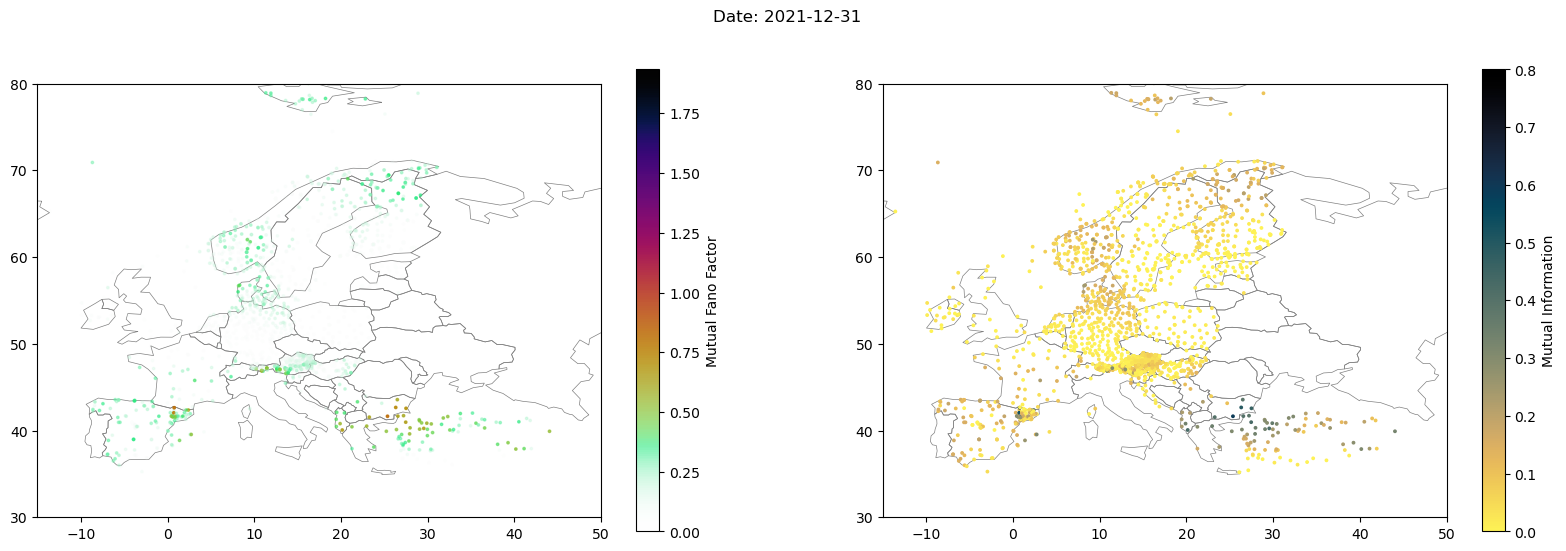

In [464]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
europe.boundary.plot(ax=ax1, lw=0.5, color='gray', zorder=-np.inf)
europe.boundary.plot(ax=ax2, lw=0.5, color='gray', zorder=-np.inf)
ax1.set_xlim(-15, 50)
ax1.set_ylim(30, 80)
ax2.set_xlim(-15, 50)
ax2.set_ylim(30, 80)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Initialize the colormaps
cmap_fano = plt.get_cmap('cmr.chroma_r')
cmap_fano._init()
cmap_fano._lut[:,-1] = np.sort(1 - np.geomspace(1e-2, 1, cmap_fano.N + 3))
cmap_fano.set_bad((0,0,0,0))

cmap_mutual = plt.get_cmap('cmr.eclipse_r')

# Create ScalarMappables for the colorbars
sm_fano = plt.cm.ScalarMappable(cmap=cmap_fano, norm=plt.Normalize(vmin=0, vmax=vmax_fano))
sm_fano.set_array([])
fig.colorbar(sm_fano, ax=ax1, label='Mutual Fano Factor')

sm_mutual = plt.cm.ScalarMappable(cmap=cmap_mutual, norm=plt.Normalize(vmin=0, vmax=0.8))
sm_mutual.set_array([])
fig.colorbar(sm_mutual, ax=ax2, label='Mutual Information')

# Initialize the scatter plots
scat_fano = ax1.scatter([], [], c=[], s=3, vmin=0, vmax=vmax_fano, cmap=cmap_fano)
scat_mutual = ax2.scatter([], [], c=[], s=3, vmin=0, vmax=0.8, cmap=cmap_mutual)

# Function to initialize the scatter plots
def init():
    scat_fano.set_offsets(np.empty((0, 2)))
    scat_fano.set_array(np.array([]))
    scat_mutual.set_offsets(np.empty((0, 2)))
    scat_mutual.set_array(np.array([]))
    return scat_fano, scat_mutual

# Function to update the scatter plots for each frame
def update(frame):
    date = dates[frame]
    data_plot_fano = precomputed_data_fano[date]
    data_plot_mutual = precomputed_data_mutual[date]
    print(f"Frame: {frame}, Date: {date}, Data Plot Fano Shape: {data_plot_fano.shape}, Data Plot Mutual Shape: {data_plot_mutual.shape}")
    if data_plot_fano.ndim == 2 and data_plot_fano.shape[0] > 0:
        scat_fano.set_offsets(data_plot_fano[:, [1, 0]])
        scat_fano.set_array(data_plot_fano[:, 2])
    else:
        scat_fano.set_offsets(np.empty((0, 2)))
        scat_fano.set_array(np.array([]))
    if data_plot_mutual.ndim == 2 and data_plot_mutual.shape[0] > 0:
        scat_mutual.set_offsets(data_plot_mutual[:, [1, 0]])
        scat_mutual.set_array(data_plot_mutual[:, 2])
    else:
        scat_mutual.set_offsets(np.empty((0, 2)))
        scat_mutual.set_array(np.array([]))
    fig.suptitle(f"Date: {date}")
    return scat_fano, scat_mutual

# Create the animation with a specified interval (e.g., 200 milliseconds)
ani = animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=100)

# Save the animation as a video file (optional)
ani.save('animation_fano_mutual_2010_2022.mp4', writer='ffmpeg')

plt.show()

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_83379/1507631887.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Mutual Fano Factor')


Frame: 0, Date: 2010-01-01, Data Plot Shape: (1820, 3)
Frame: 1, Date: 2010-01-02, Data Plot Shape: (1828, 3)
Frame: 2, Date: 2010-01-03, Data Plot Shape: (1828, 3)
Frame: 3, Date: 2010-01-04, Data Plot Shape: (1835, 3)
Frame: 4, Date: 2010-01-05, Data Plot Shape: (1835, 3)
Frame: 5, Date: 2010-01-06, Data Plot Shape: (1840, 3)
Frame: 6, Date: 2010-01-07, Data Plot Shape: (1841, 3)
Frame: 7, Date: 2010-01-08, Data Plot Shape: (1840, 3)
Frame: 8, Date: 2010-01-09, Data Plot Shape: (1840, 3)
Frame: 9, Date: 2010-01-10, Data Plot Shape: (1838, 3)
Frame: 10, Date: 2010-01-11, Data Plot Shape: (1842, 3)
Frame: 11, Date: 2010-01-12, Data Plot Shape: (1843, 3)
Frame: 12, Date: 2010-01-13, Data Plot Shape: (1840, 3)
Frame: 13, Date: 2010-01-14, Data Plot Shape: (1840, 3)
Frame: 14, Date: 2010-01-15, Data Plot Shape: (1838, 3)
Frame: 15, Date: 2010-01-16, Data Plot Shape: (1834, 3)
Frame: 16, Date: 2010-01-17, Data Plot Shape: (1840, 3)
Frame: 17, Date: 2010-01-18, Data Plot Shape: (1843, 3)
Fr

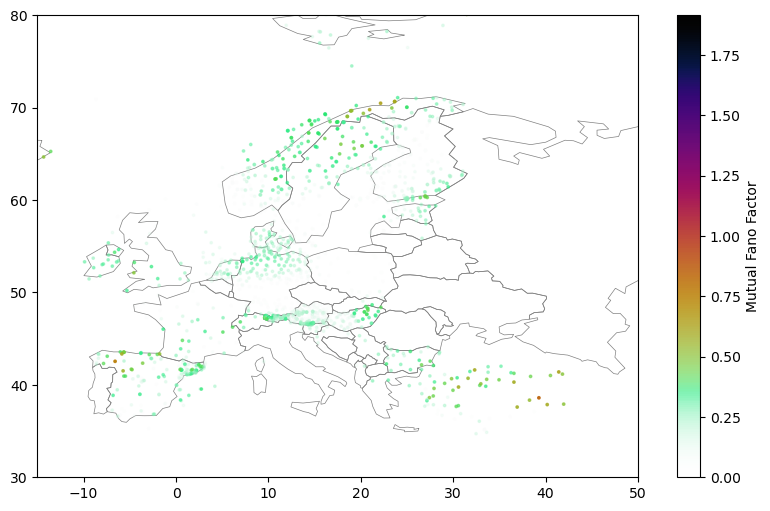

In [447]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
europe.boundary.plot(ax=ax, lw=0.5, color='gray', zorder=-np.inf)
plt.xlim(-15, 50)
plt.ylim(30, 80)
ax.set_aspect('equal')

cmap = plt.get_cmap('cmr.chroma_r')
# add transparency
cmap._init()
cmap._lut[:,-1] = np.sort(1 - np.geomspace(1e-2, 1, cmap.N + 3))
cmap.set_bad((0,0,0,0))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
plt.colorbar(sm, label='Mutual Fano Factor')

# Initialize the scatter plot
scat = ax.scatter([], [], c=[], s=3, vmin=vmin, vmax=vmax, cmap = cmap)


# Function to initialize the scatter plot
def init():
    scat.set_offsets(np.empty((0, 2)))
    scat.set_array(np.array([]))
    return scat,

# Function to update the scatter plot for each frame
def update(frame):
    date = dates[frame]
    data_plot = precomputed_data[date]
    print(f"Frame: {frame}, Date: {date}, Data Plot Shape: {data_plot.shape}")
    if data_plot.ndim == 2 and data_plot.shape[0] > 0:
        scat.set_offsets(data_plot[:, [1, 0]])
        scat.set_array(data_plot[:, 2])
    else:
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array(np.array([]))
    return scat,

# Create the animation with a specified interval (e.g., 200 milliseconds)
ani = animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=60)

# Save the animation as a video file (optional)
ani.save('animation_fano_2010_2012.mp4', writer='ffmpeg')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
europe.boundary.plot(ax=ax, lw=0.5, color='gray', zorder=-np.inf)
plt.xlim(-15, 50)
plt.ylim(30, 80)
ax.set_aspect('equal')

cmap = plt.get_cmap('cmr.chroma_r')
# add transparency
cmap._init()
cmap._lut[:,-1] = np.sort(1 - np.geomspace(1e-2, 1, cmap.N + 3))
cmap.set_bad((0,0,0,0))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
plt.colorbar(sm, label='Mutual Fano Factor')

# Initialize the scatter plot
scat = ax.scatter([], [], c=[], s=3, vmin=vmin, vmax=vmax, cmap = cmap)


# Function to initialize the scatter plot
def init():
    scat.set_offsets(np.empty((0, 2)))
    scat.set_array(np.array([]))
    return scat,

# Function to update the scatter plot for each frame
def update(frame):
    date = dates[frame]
    data_plot = precomputed_data[date]
    print(f"Frame: {frame}, Date: {date}, Data Plot Shape: {data_plot.shape}")
    if data_plot.ndim == 2 and data_plot.shape[0] > 0:
        scat.set_offsets(data_plot[:, [1, 0]])
        scat.set_array(data_plot[:, 2])
    else:
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array(np.array([]))
    return scat,

# Create the animation with a specified interval (e.g., 200 milliseconds)
ani = animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=60)

# Save the animation as a video file (optional)
ani.save('animation_fano_2010_2012.mp4', writer='ffmpeg')

plt.show()

array([   0,    1,    2, ..., 2187, 2188, 2189])

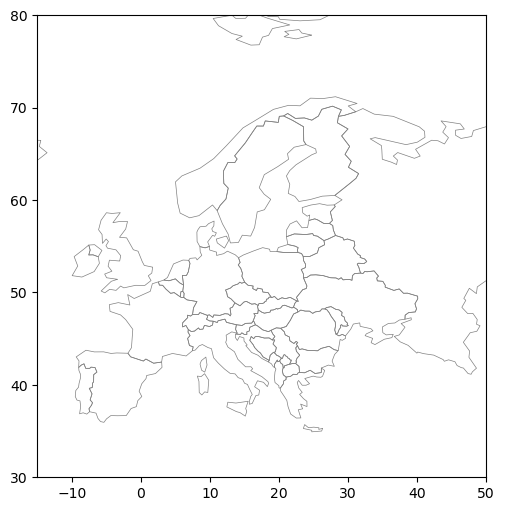

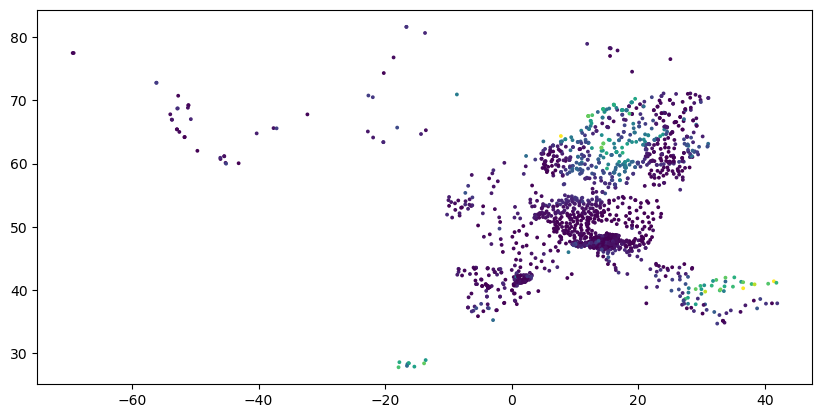

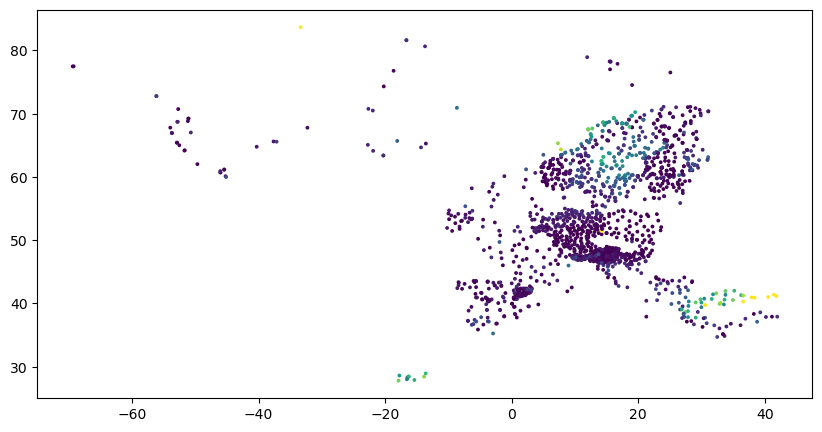

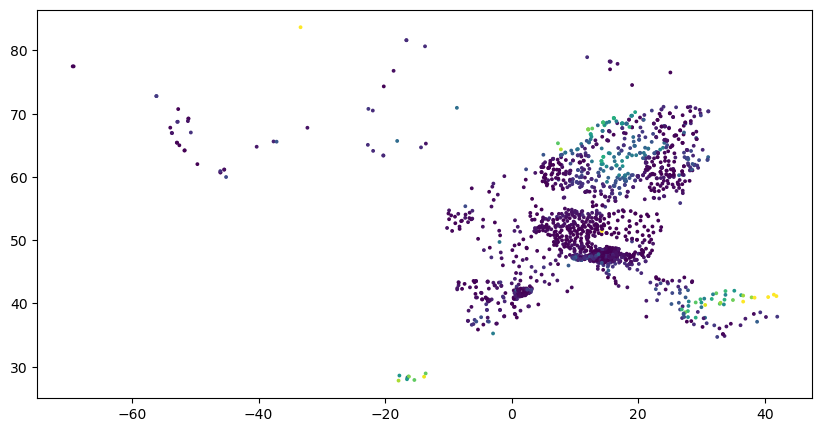

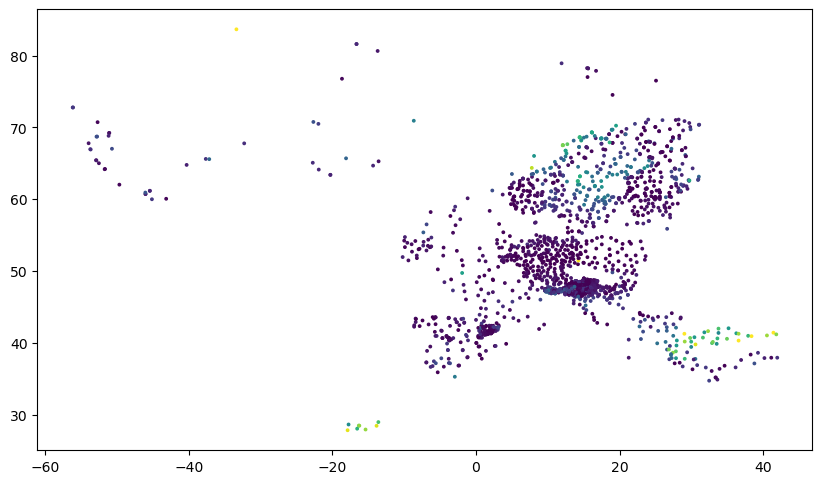

KeyboardInterrupt: 

In [270]:
# make an animation
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10,6))
europe.boundary.plot(ax=ax, lw=0.5, color = 'gray', zorder = -np.inf)
plt.xlim(-15, 50)
plt.ylim(30, 80)

for counter,date in enumerate(np.arange(np.datetime64('2010-01-01'), np.datetime64('2015-12-31'))):
    data_plot = []
    for stat_id in mutual_fano.keys():
        fano = mutual_fano[stat_id]
        location = stations_df[stations_df['STAID'] == stat_id][['LAT','LON']].values.flatten()
        values = fano.values[fano.index==date]
        
        if(len(values) == 0):
            continue
        data_plot.append((location[0], location[1], values[0]))
        
        
    data_plot = np.array(data_plot)
    fig, ax = plt.subplots(figsize=(10,6))
    plt.scatter(data_plot[:,1], data_plot[:,0], c= 2 - data_plot[:,2], s=3, vmin=0.0, vmax=0.5)
    ax.set_aspect('equal')
    plt.show()